# Creating a newsworthiness detector

In this notebook we will be creating a newsworthiness detector. Its aim is to be the first discriminating layer in our system to classify online news content, dividing newsworthy content from not newsworthy.

Ideally, we want this classifier to divide the content as follows:
 - news
 - opinions
 - uninteresting content (personal posts)


## Data

Firstly, we will take care of gathering enough data for our purposes.

### Import and install

In [ ]:
import pandas as pd
import requests
import time

In [ ]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 5.8MB/s 
     |████████████████████████████████| 7.4MB 26.2MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3355 sha256=41b095ad89dca2838179999c652b71fc5d09d7a6bdad41445a58735a636b7a52
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=90a0c08d907a9f6445772b67722bb32eddcc5bdf38c5e7e3fa790a300604f6df
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13538 sha256=c731f297e30d7c0f070ad40f185634f0d9d6df1f00d2cb27739957f515374aac
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c77

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
drive_service = build('drive', 'v3', cache_discovery=False)

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
url = "https://api.pushshift.io/reddit/search/submission"

def crawl_page(subreddit: str, sort_by: str, last_page = None):
  
  params = {"subreddit": subreddit, "size": 500, "sort": "desc", "sort_type": sort_by}
  if last_page is not None:
    if len(last_page) > 0:
      # resume from where we left at the last page
      params["before"] = last_page[-1][sort_by]
    else:
      # the last page was empty, we are past the last page
      return []
  results = requests.get(url, params)
  if not results.ok:
    # something wrong happened
    raise Exception("Server returned status code {}".format(results.status_code))
  return results.json()["data"]

def crawl_subreddit(subreddit, sort_by, max_submissions = 1000000):
  
  submissions = []
  last_page = None
  while last_page != [] and len(submissions) < max_submissions:
    try:
      last_page = crawl_page(subreddit, sort_by, last_page)
    except:
      break
    submissions += last_page
    print(str(len(submissions)) + str(" posts obtained out of ") + str(max_submissions))
    time.sleep(2)
  return submissions[:max_submissions]

### News dataset

For examples of news, we will be using the *subreddit r/news*. As specified in their rules, opinion pieces, analysis or discussion are not allowed, as well as articles that aren't newsworthy.

This makes it the perfect dataset for us. The creation of the dataset is shown [here](https://colab.research.google.com/drive/1YLf4xG7IYTndW55Q80dOaDXukIJYdD8m#scrollTo=-eUnypMrL0el)

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1fw7nWRBn5ssLUjd2A2R-CREzeqZptroD/view?usp=sharing', 'high_quality_articles_second_0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ai5vV2m9rTauM_LYMnrNt4FM1RBXByHP/view?usp=sharing', 'high_quality_articles_second_1.csv')
upload_from_drive('https://drive.google.com/file/d/1bP-qE5kwmUKX0To40PMDFI2baQxhT-eA/view?usp=sharing', 'high_quality_articles_second_2.csv')
upload_from_drive('https://drive.google.com/file/d/1lQjDTsMf-EgIyyaNil0N9P5UeiSDfqlG/view?usp=sharing', 'high_quality_articles_second_3.csv')
upload_from_drive('https://drive.google.com/file/d/1rBeGJiLrlj-4OT8ez06DDzyHyN8H6Eet/view?usp=sharing', 'high_quality_articles_second_4.csv')
upload_from_drive('https://drive.google.com/file/d/1u_LJ1E4c_ZjLVABy6ySUtyId23zx4AcG/view?usp=sharing', 'high_quality_articles_second_5.csv')

In [ ]:
df_news = pd.DataFrame()
for i in range(0,6):
  df_news = pd.concat([df_news, pd.read_csv('high_quality_articles_second_' + str(i) + '.csv')])

df_news = df_news.drop(columns=['publisher', 'url'], axis=1)
df_news['text'] = df_news['text'].astype(str)
df_news = df_news.drop_duplicates()
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17569 entries, 0 to 4316
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17569 non-null  object
dtypes: object(1)
memory usage: 274.5+ KB


### Opinion dataset

For examples of opinion pieces and in-depth analysis, we will be using *subreddit r/inthenews*, which, according to its description, "is the subreddit for opinion, analysis, and discussion of recent events."

#### Scraping articles from Reddit

In [ ]:
df_opinions = pd.DataFrame(crawl_subreddit('news', 'created_utc'))
df_opinions.to_csv('opinion_dataset.csv', index=False)
save_file_to_drive('opinion_dataset.csv', 'opinion_dataset.csv')

100 posts obtained out of 1000000
200 posts obtained out of 1000000
300 posts obtained out of 1000000
400 posts obtained out of 1000000
500 posts obtained out of 1000000
600 posts obtained out of 1000000
700 posts obtained out of 1000000
800 posts obtained out of 1000000
900 posts obtained out of 1000000
1000 posts obtained out of 1000000
1100 posts obtained out of 1000000
1200 posts obtained out of 1000000
1300 posts obtained out of 1000000
1400 posts obtained out of 1000000
1500 posts obtained out of 1000000
1600 posts obtained out of 1000000
1700 posts obtained out of 1000000
1800 posts obtained out of 1000000
1900 posts obtained out of 1000000
2000 posts obtained out of 1000000
2100 posts obtained out of 1000000
2200 posts obtained out of 1000000
2300 posts obtained out of 1000000
2400 posts obtained out of 1000000
2500 posts obtained out of 1000000
2600 posts obtained out of 1000000
2700 posts obtained out of 1000000
2800 posts obtained out of 1000000
2900 posts obtained out of 10

{'id': '1zTVhNst_4I3KGaY3OUY5-HoIhfT9wO_H'}

In [ ]:
df_opinions['dummy'] = 1
df_opinions.groupby(by='domain').count().sort_values(by='dummy', ascending=False)[:40]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media,media_embed,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,removed_by_category,retrieved_on,score,secure_media,secure_media_embed,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,treatment_tags,upvote_ratio,url,url_overridden_by_dest,whitelist_status,wls,link_flair_text,author_flair_background_color,author_flair_text_color,link_flair_template_id,author_cakeday,distinguished,crosspost_parent,crosspost_parent_list,gilded,dummy
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
popularnews.in,29668,29668,29668,0,29668,0,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,29668,0,0,29668,29668,29668,29668,29668,29668,29668,29668,25631,25631,29668,29663,29668,29668,0,0,29668,29668,29668,29668,29668,29668,29668,29668,29668,25913,25913,29668,29668,29668,29668,29668,29668,29668,29668,105,0,0,0,0,0,0,0,0,29668
techfans.co.uk,16925,16925,16925,0,16925,0,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,16925,0,0,16925,16925,16925,16925,16925,16925,16925,16925,15888,15888,16925,16924,16925,16925,0,0,16925,16925,16925,16925,16925,16925,16925,16925,16925,16056,16056,16925,16925,16925,16925,16925,16925,16925,16925,20,0,0,0,135,0,0,0,0,16925
yakanak.tumblr.com,15684,15684,15684,0,15684,0,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,15684,0,0,15684,15684,15684,15684,15684,15684,15684,15684,14746,14746,15684,15679,15684,15684,0,0,15684,15684,15684,15684,15684,15684,15684,15684,15684,14845,14845,15684,15684,15684,15684,15684,15684,15684,15684,0,0,0,0,0,0,0,0,0,15684
corealpha.org,15185,15185,15185,0,15185,0,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,15185,0,0,15185,15185,15185,15185,15185,15185,15185,15185,578,578,15185,15185,15185,15185,0,0,15185,15185,15185,15185,15185,15185,15185,15185,15185,707,707,15185,15185,15185,15185,15185,15185,15185,15185,156,0,0,0,0,0,0,0,0,15185
tamilidhal.com,14419,14419,14419,0,14419,0,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,14419,0,0,14419,14419,14419,14419,14419,14419,14419,14419,4518,4518,14419,14419,14419,14419,0,0,14419,14419,14419,14419,14419,14419,14419,14419,14419,4595,4595,14419,14419,14419,14419,14419,14419,14419,14419,0,0,0,0,0,0,0,0,0,14419
en.neroonews.com,13379,13379,13379,0,13379,0,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,13379,0,0,13379,13379,13379,13379,13379,13379,13379,13379,10062,10062,13379,13379,13379,13379,0,0,13379,13379,13379,13379,13379,13379,13379,13379,13379,10211,10211,13379,13379,13379,13379,13379,13379,13379,13379,146,0,0,0,0,0,0,0,0,13379
gossipmantri.com,11542,11542,11542,0,11542,0,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,11542,0,0,11542,11542,11542,11542,11542,11542,11542,11542,10679,10679,11542,11541,11542,11542,0,0,11542,11542,11542,11542,11542,11542,11542,11542,11542,10760,10760,11542,11542,11542,11542,11542,11542,1

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1zTVhNst_4I3KGaY3OUY5-HoIhfT9wO_H/view?usp=sharing','opinion_dataset.csv')
df_opinions = pd.read_csv('opinion_dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,5,70,71,72,73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_opinions = df_opinions[~df_opinions['domain'].isin(['youtu.be', 'youtube.com', 'nytimes.com'])]

In [ ]:
df_opinions_first = df_opinions[:30000]

In [ ]:
from newspaper import Article
from newspaper import Config
import nltk
nltk.download('punkt')

USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = USER_AGENT

articles = []
domains = {}

def retrieveArticles(link, domain):
  
  #To allow a faster scraping process
  if domain in domains:
    if time.time() - domains[domain] < 1:
      time.sleep(1)
  domains[domain] = time.time()

  try:
    article = Article(link, config=config)
    article.download()
    article.parse()
    article.nlp()
  except:
    print("Error with link ", link)
    return
  
  article_info = {}
  article_info['url'] = link
  article_info['publisher'] = domain
  article_info['text'] = article.text

  global articles
  articles.append(article_info)
  print("Retrieved {0}/{1} articles ({2:.2f}%)".format(5000*(index) + len(articles), len(df_opinions_first), (5000*(index) + len(articles))*100/len(df_opinions_first)))

start_point = 0
finish_point = len(df_opinions_first)
step = 5000
index = 0

while start_point < finish_point:
  
  #left
  df_partial_opinions = df_opinions_first[start_point:start_point+step]
  articles = []
  df_partial_opinions.apply(lambda row: retrieveArticles(row['url'], row['domain']), axis=1)
  pd.DataFrame(articles).to_csv('opinions' + str(index) + '.csv', index=False)
  save_file_to_drive('opinions' + str(index) + '.csv', 'opinions' + str(index) + '.csv')

  index += 1
  start_point += step

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Retrieved 1/30000 articles (0.00%)
Retrieved 2/30000 articles (0.01%)
Retrieved 3/30000 articles (0.01%)
Retrieved 4/30000 articles (0.01%)
Retrieved 5/30000 articles (0.02%)
Retrieved 6/30000 articles (0.02%)
Retrieved 7/30000 articles (0.02%)
Retrieved 8/30000 articles (0.03%)
Retrieved 9/30000 articles (0.03%)
Error with link  https://www.malangtimes.com/baca/60212/20201114/174800/booking-segera-perumahan-taman-tirta-malang-beri-diskon-hingga-10
Error with link  https://www.malangtimes.com/baca/60211/20201114/172700/bangun-wisata-ruang-terbuka-hijau-seperti-pujon-kidul-curungrejo-tingkatkan-pades
Error with link  https://www.malangtimes.com/baca/60210/20201114/172300/kasun-aniaya-pemuda-tahan-lama-di-lokalisasi-pemerintahan-dusun-kosong-jabatan
Retrieved 10/30000 articles (0.03%)
Retrieved 11/30000 articles (0.04%)
Retrieved 12/30000 articles (0.04%)
Retrieved 13/30000 arti

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Retrieved 2878/30000 articles (9.59%)
Retrieved 2879/30000 articles (9.60%)
Retrieved 2880/30000 articles (9.60%)
Retrieved 2881/30000 articles (9.60%)
Retrieved 2882/30000 articles (9.61%)
Retrieved 2883/30000 articles (9.61%)
Retrieved 2884/30000 articles (9.61%)
Retrieved 2885/30000 articles (9.62%)
Retrieved 2886/30000 articles (9.62%)
Retrieved 2887/30000 articles (9.62%)
Retrieved 2888/30000 articles (9.63%)
Retrieved 2889/30000 articles (9.63%)
Retrieved 2890/30000 articles (9.63%)
Retrieved 2891/30000 articles (9.64%)
Retrieved 2892/30000 articles (9.64%)
Retrieved 2893/30000 articles (9.64%)
Retrieved 2894/30000 articles (9.65%)
Retrieved 2895/30000 articles (9.65%)
Retrieved 2896/30000 articles (9.65%)
Retrieved 2897/30000 articles (9.66%)
Retrieved 2898/30000 articles (9.66%)
Retrieved 2899/30000 articles (9.66%)
Retrieved 2900/30000 articles (9.67%)
Retrieved 2901/30000 articles (9.67%)
Retrieved 2902/30000 articles (9.67%)
Retrieved 2903/30000 articles (9.68%)
Retrieved 29

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Retrieved 3467/30000 articles (11.56%)
Retrieved 3468/30000 articles (11.56%)
Retrieved 3469/30000 articles (11.56%)
Retrieved 3470/30000 articles (11.57%)
Retrieved 3471/30000 articles (11.57%)
Retrieved 3472/30000 articles (11.57%)
Retrieved 3473/30000 articles (11.58%)
Retrieved 3474/30000 articles (11.58%)
Retrieved 3475/30000 articles (11.58%)
Retrieved 3476/30000 articles (11.59%)
Retrieved 3477/30000 articles (11.59%)
Retrieved 3478/30000 articles (11.59%)
Retrieved 3479/30000 articles (11.60%)
Retrieved 3480/30000 articles (11.60%)
Retrieved 3481/30000 articles (11.60%)
Retrieved 3482/30000 articles (11.61%)
Retrieved 3483/30000 articles (11.61%)
Retrieved 3484/30000 articles (11.61%)
Retrieved 3485/30000 articles (11.62%)
Retrieved 3486/30000 articles (11.62%)
Retrieved 3487/30000 articles (11.62%)
Retrieved 3488/30000 articles (11.63%)
Retrieved 3489/30000 articles (11.63%)
Retrieved 3490/30000 articles (11.63%)
Retrieved 3491/30000 articles (11.64%)
Retrieved 3492/30000 arti

Building prefix dict from /usr/local/lib/python3.6/dist-packages/jieba/dict.txt ...


Retrieved 4622/30000 articles (15.41%)


Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.4838037490844727 seconds.
Prefix dict has been built succesfully.


Retrieved 4623/30000 articles (15.41%)
Retrieved 4624/30000 articles (15.41%)
Retrieved 4625/30000 articles (15.42%)
Retrieved 4626/30000 articles (15.42%)
Retrieved 4627/30000 articles (15.42%)
Retrieved 4628/30000 articles (15.43%)
Retrieved 4629/30000 articles (15.43%)
Retrieved 4630/30000 articles (15.43%)
Retrieved 4631/30000 articles (15.44%)
Retrieved 4632/30000 articles (15.44%)
Retrieved 4633/30000 articles (15.44%)
Retrieved 4634/30000 articles (15.45%)
Retrieved 4635/30000 articles (15.45%)
Retrieved 4636/30000 articles (15.45%)
Retrieved 4637/30000 articles (15.46%)
Retrieved 4638/30000 articles (15.46%)
Retrieved 4639/30000 articles (15.46%)
Retrieved 4640/30000 articles (15.47%)
Retrieved 4641/30000 articles (15.47%)
Retrieved 4642/30000 articles (15.47%)
Retrieved 4643/30000 articles (15.48%)
Retrieved 4644/30000 articles (15.48%)
Retrieved 4645/30000 articles (15.48%)
Retrieved 4646/30000 articles (15.49%)
Retrieved 4647/30000 articles (15.49%)
Retrieved 4648/30000 arti

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Retrieved 8379/30000 articles (27.93%)
Retrieved 8380/30000 articles (27.93%)
Retrieved 8381/30000 articles (27.94%)
Retrieved 8382/30000 articles (27.94%)
Retrieved 8383/30000 articles (27.94%)
Retrieved 8384/30000 articles (27.95%)
Retrieved 8385/30000 articles (27.95%)
Retrieved 8386/30000 articles (27.95%)
Retrieved 8387/30000 articles (27.96%)
Retrieved 8388/30000 articles (27.96%)
Retrieved 8389/30000 articles (27.96%)
Retrieved 8390/30000 articles (27.97%)
Retrieved 8391/30000 articles (27.97%)
Retrieved 8392/30000 articles (27.97%)
Retrieved 8393/30000 articles (27.98%)
Retrieved 8394/30000 articles (27.98%)
Retrieved 8395/30000 articles (27.98%)
Retrieved 8396/30000 articles (27.99%)
Retrieved 8397/30000 articles (27.99%)
Retrieved 8398/30000 articles (27.99%)
Retrieved 8399/30000 articles (28.00%)
Error with link  https://www.washingtonpost.com/us-policy/2020/11/10/trump-federal-budget-post-election/
Retrieved 8400/30000 articles (28.00%)
Retrieved 8401/30000 articles (28.00%

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33434
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33437
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 0. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Output streaming troncato alle ultime 5000 righe.
Retrieved 21043/30000 articles (70.14%)
Retrieved 21044/30000 articles (70.15%)
Retrieved 21045/30000 articles (70.15%)
Retrieved 21046/30000 articles (70.15%)
Retrieved 21047/30000 articles (70.16%)
Retrieved 21048/30000 articles (70.16%)
Retrieved 21049/30000 articles (70.16%)
Retrieved 21050/30000 articles (70.17%)
Retrieved 21051/30000 articles (70.17%)
Retrieved 21052/30000 articles (70.17%)
Retrieved 21053/30000 articles (70.18%)
Retrieved 21054/30000 articles (70.18%)
Retrieved 21055/30000 articles (70.18%)
Retrieved 21056/30000 articles (70.19%)
Retrieved 21057/30000 articles (70.19%)
Retrieved 21058/30000 articles (70.19%)
Retrieved 21059/30000 articles (70.20%)
Retrieved 21060/30000 articles (70.20%)
Retrieved 21061/30000 articles (70.20%)
Retrieved 21062/30000 articles (70.21%)
Retrieved 21063/30000 articles (70.21%)
Error with link  https://blog.thefatburningformula.com/2020/11/04/madison-cawthorn-wins-in-north-carolina-beco

#### Merging all the articles together

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1O2UDUi025Z827vNgZI9q5Z3RYAyP-OZ5/view?usp=sharing', 'opinions0.csv')
upload_from_drive('https://drive.google.com/file/d/1ktJhb2OxmEYuc09XJR4bz8m5A0lKmpGT/view?usp=sharing', 'opinions1.csv')
upload_from_drive('https://drive.google.com/file/d/1EEnPThfkuHaYlqc7aQ-3OkZ2t9UVbS0T/view?usp=sharing', 'opinions2.csv')
upload_from_drive('https://drive.google.com/file/d/12yyNWB7EXKzBv6ooAmIpLFi360Cp777g/view?usp=sharing', 'opinions3.csv')
upload_from_drive('https://drive.google.com/file/d/1TcTMdUZ8h5rR1IH2aZNWn3d_MWXBOpLA/view?usp=sharing', 'opinions4.csv')

In [ ]:
df_opinions = pd.DataFrame()
for i in range(0,5):
  df_opinions = pd.concat([df_opinions, pd.read_csv('opinions' + str(i) + '.csv')])

df_opinions = df_opinions.drop(columns=['publisher', 'url'], axis=1)
df_opinions['text'] = df_opinions['text'].astype(str)
df_opinions = df_opinions.drop_duplicates()
df_opinions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15816 entries, 0 to 4713
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15816 non-null  object
dtypes: object(1)
memory usage: 247.1+ KB


### Uninteresting content (personal posts)

For this last section, we will be using a Blog corpus found on Kaggle, a collection of blog posts from 2004, available [here](https://www.kaggle.com/rtatman/blog-authorship-corpus).

#### Retrieve data from Kaggle

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1dji-tC4sIQoBoXxDP4h2bo36D_N005Dg/view?usp=sharing', 'blogtext.csv.zip')
!unzip blogtext.csv.zip

Archive:  blogtext.csv.zip
  inflating: blogtext.csv            


In [ ]:
df_uninteresting = pd.read_csv('blogtext.csv')
df_uninteresting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [ ]:
df_uninteresting['topic'].unique()

array(['Student', 'InvestmentBanking', 'indUnk', 'Non-Profit', 'Banking',
       'Education', 'Engineering', 'Science', 'Communications-Media',
       'BusinessServices', 'Sports-Recreation', 'Arts', 'Internet',
       'Museums-Libraries', 'Accounting', 'Technology', 'Law',
       'Consulting', 'Automotive', 'Religion', 'Fashion', 'Publishing',
       'Marketing', 'LawEnforcement-Security', 'HumanResources',
       'Telecommunications', 'Military', 'Government', 'Transportation',
       'Architecture', 'Advertising', 'Agriculture', 'Biotech',
       'RealEstate', 'Manufacturing', 'Construction', 'Chemicals',
       'Maritime', 'Tourism', 'Environment'], dtype=object)

We remove those topics that could be considered as close to news

In [ ]:
topics_to_remove = [
                    'Communications-Media', 'Law', 'LawEnforcement-Security',
                    'Military', 'Government'
]
df_uninteresting = df_uninteresting[~df_uninteresting['topic'].isin(topics_to_remove)]

We remove the columns we're not interested in

In [ ]:
df_uninteresting = df_uninteresting.drop(df_uninteresting.columns.difference(['text']), axis=1)
df_uninteresting.to_csv('uninteresting.csv', index=False)
save_file_to_drive('uninteresting.csv', 'uninteresting.csv')

File ID: 13fdKm3q90jQMknTkUtJbyMebWDbjViMR


{'id': '13fdKm3q90jQMknTkUtJbyMebWDbjViMR'}

#### Create final dataset

In [ ]:
upload_from_drive('https://drive.google.com/file/d/13fdKm3q90jQMknTkUtJbyMebWDbjViMR/view?usp=sharing', 'uninteresting.csv')

We sample the dataset, so to make it more balanced with the other two

In [ ]:
df_uninteresting = pd.read_csv('uninteresting.csv')
df_uninteresting = df_uninteresting.sample(n=20000)

## Training the models

### Import and install

In [ ]:
!pip3 install -q tensorflow_gpu==2.3.0

     |████████████████████████████████| 320.4MB 55kB/s 


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 118kB/s 
     |████████████████████████████████| 983kB 51.6MB/s 
     |████████████████████████████████| 266kB 49.4MB/s 
     |████████████████████████████████| 1.3MB 52.1MB/s 
     |████████████████████████████████| 471kB 42.5MB/s 
     |████████████████████████████████| 890kB 49.2MB/s 
     |████████████████████████████████| 1.1MB 50.9MB/s 
     |████████████████████████████████| 2.9MB 54.6MB/s 


In [ ]:
import tensorflow as tf
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-multilingual-uncased'
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

### Merge the dataset

In [ ]:
df_news['target'] = 'news'
df_opinions['target'] = 'opinion'
df_uninteresting['target'] = 'uninteresting'

df_final = pd.concat([df_news, df_opinions, df_uninteresting])

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53385 entries, 0 to 628373
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    53385 non-null  object
 1   target  53385 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Train the models

#### First try: one detector, three categories
The first model we will be training is composed of only one detector that takes a text and distinguishes it between news/opinion/uninteresting

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_final, 
                                                                   text_column='text',
                                                                   label_columns=["target"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1780/1780 [==============================] - 1041s 585ms/step - loss: 0.7065 - accuracy: 0.6554
Epoch 2/5
1780/1780 [==============================] - 1036s 582ms/step - loss: 0.4249 - accuracy: 0.7692
Epoch 3/5
1780/1780 [==============================] - 1037s 583ms/step - loss: 1.0825 - accuracy: 0.4050
Epoch 4/5
1780/1780 [==============================] - 1037s 582ms/step - loss: 1.9629 - accuracy: 0.3388


done.
Visually inspect loss plot and select learning rate associated with falling loss


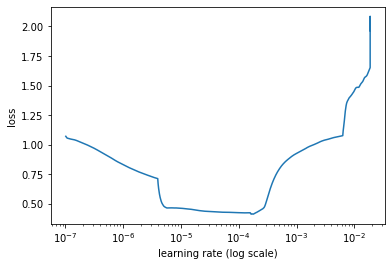

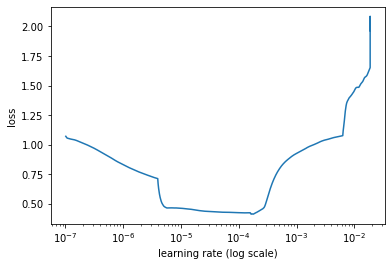

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
1780/1780 [==============================] - 306s 172ms/step - loss: 0.7906 - accuracy: 0.6047 - val_loss: 0.6583 - val_accuracy: 0.6579
Epoch 2/4
1780/1780 [==============================] - 302s 170ms/step - loss: 0.6279 - accuracy: 0.6680 - val_loss: 0.6183 - val_accuracy: 0.6731
Epoch 3/4
1780/1780 [==============================] - 302s 170ms/step - loss: 0.5921 - accuracy: 0.6855 - val_loss: 0.5817 - val_accuracy: 0.6808
Epoch 4/4
1780/1780 [==============================] - 302s 170ms/step - loss: 0.5769 - accuracy: 0.6961 - val_loss: 0.5738 - val_accuracy: 0.7044


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      3545
           1       0.57      0.46      0.51      3179
           2       0.91      0.94      0.92      3953

    accuracy                           0.70     10677
   macro avg       0.69      0.69      0.68     10677
weighted avg       0.70      0.70      0.70     10677



array([[2340, 1018,  187],
       [1533, 1461,  185],
       [ 163,   70, 3720]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save('newsworthiness_detector')
save_file_to_drive('tf_model_first.h5', 'newsworthiness_detector/tf_model.h5')
save_file_to_drive('tf_model_first.preproc', 'newsworthiness_detector/tf_model.preproc')

File ID: 1l4hKGd-uwbPB14jDXGrRkJVpOZTpa0Fa
File ID: 1hdAQfpLrfVPEn5W7Xl8bGaxoj4PUjOi8


{'id': '1hdAQfpLrfVPEn5W7Xl8bGaxoj4PUjOi8'}

#### Second try: two models
In the second try, we will be training two models: one to distinguish between interesting/uninteresting, one to distinguish between news/opinion

 ##### First model: news vs opinions

In [ ]:
df = pd.concat([df_news, df_opinions])

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=["target"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1113/1113 [==============================] - 646s 581ms/step - loss: 0.7296 - accuracy: 0.5288
Epoch 2/5
1113/1113 [==============================] - 646s 580ms/step - loss: 0.6003 - accuracy: 0.6486
Epoch 3/5
1113/1113 [==============================] - 646s 581ms/step - loss: 0.7068 - accuracy: 0.5211
Epoch 4/5
1113/1113 [==============================] - 643s 578ms/step - loss: 3.3272 - accuracy: 0.4966


done.
Visually inspect loss plot and select learning rate associated with falling loss


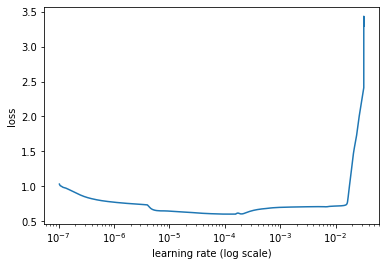

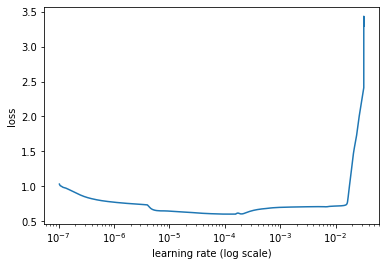

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
1113/1113 [==============================] - 194s 174ms/step - loss: 0.6939 - accuracy: 0.5300 - val_loss: 0.6833 - val_accuracy: 0.5582
Epoch 2/4
1113/1113 [==============================] - 189s 170ms/step - loss: 0.6850 - accuracy: 0.5549 - val_loss: 0.6846 - val_accuracy: 0.5706
Epoch 3/4
1113/1113 [==============================] - 189s 169ms/step - loss: 0.6805 - accuracy: 0.5644 - val_loss: 0.6791 - val_accuracy: 0.5574
Epoch 4/4
1113/1113 [==============================] - 189s 170ms/step - loss: 0.6729 - accuracy: 0.5820 - val_loss: 0.6711 - val_accuracy: 0.5756


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.60      0.61      0.60      3525
           1       0.55      0.54      0.55      3152

    accuracy                           0.58      6677
   macro avg       0.57      0.57      0.57      6677
weighted avg       0.58      0.58      0.58      6677



array([[2139, 1386],
       [1448, 1704]])

##### Second model: interesting vs uninteresting

In [ ]:
df_news['is_interesting'] = True
df_opinions['is_interesting'] = True
df_uninteresting['is_interesting'] = False
df = pd.concat([df_news, df_opinions, df_uninteresting])

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=["is_interesting"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1780/1780 [==============================] - 1036s 582ms/step - loss: 0.3226 - accuracy: 0.8523
Epoch 2/5
1641/1780 [==========================>...] - ETA: 1:20 - loss: 0.0555 - accuracy: 0.9820

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
1780/1780 [==============================] - 189s 106ms/step - loss: 0.3513 - accuracy: 0.8609 - val_loss: 0.1995 - val_accuracy: 0.9332
Epoch 2/4
1780/1780 [==============================] - 186s 104ms/step - loss: 0.1904 - accuracy: 0.9332 - val_loss: 0.1487 - val_accuracy: 0.9461
Epoch 3/4
1780/1780 [==============================] - 186s 104ms/step - loss: 0.1619 - accuracy: 0.9421 - val_loss: 0.1357 - val_accuracy: 0.9514
Epoch 4/4
1780/1780 [==============================] - 186s 104ms/step - loss: 0.1520 - accuracy: 0.9454 - val_loss: 0.1329 - val_accuracy: 0.9529


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4055
           1       0.96      0.97      0.96      6622

    accuracy                           0.95     10677
   macro avg       0.95      0.95      0.95     10677
weighted avg       0.95      0.95      0.95     10677



array([[3780,  275],
       [ 228, 6394]])